<a href="https://colab.research.google.com/github/salama4ai/AI-project/blob/main/PyTorch_model_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is for preprocessing the data and implementing the model using Pytorch library

In [1]:
# installing torchmetrics library to our colab notebook
!pip install torchmetrics

# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import joblib
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.regression import R2Score,

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.8 MB/s eta 0:00:00


In [2]:
# this line to select the GPU as an engine for doing the work if it's possible, else it selects the 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=7
set_random_seed(seed=seed)

In [3]:
# read the csv data file
x = pd.read_csv("/content/drive/MyDrive/Mabrains-project/Mabrains-data/mabrains.csv")

In [4]:
# show the first 5 rows
x.head()

,vds,L(um),W(um),vgs,vsb,corner,id(uA)
0,-0.45,8.0,0.84,0.0,0.0,tt,0.034866
1,-0.40,8.0,0.84,0.0,0.0,tt,0.009451
2,-0.35,8.0,0.84,0.0,0.0,tt,0.002331
3,-0.30,8.0,0.84,0.0,0.0,tt,0.000532
4,-0.25,8.0,0.84,0.0,0.0,tt,0.000111


# Preprocessing & Feature-Engineering

1- i will convert corner column into one hot encoded columns

2-i will convert the 2 columns 'W(um)' and L(um) into one column by dividing W/L as stated in the equation, that for 2 reasons,
- firstly to reduce number of columns without losing them contained information,
- and secondly as that is exactly how the equation used these 2 variables

- i will also apply on W/L resulting column minmaxscaler method, to make sure that the high values in this column will not dominate the model calculations and thus the model decision just due to containing high values

- also as i showed in the EDA note book that 'Temperature' and 'drain_length(um)' columns can be deleted safely as each of them contains only a single unique repeated value, thus the entropy in each of them are zero and the information that they will contripute to the model are also zeros, so removing them will not represent any losing, yet by including them in the model we increase curse-of-dimentionality and make it's harded for the model to extract the underlying knowledge from the other columns.

In [5]:
# lets convert the 2 columns 'W(um)' and L(um) into one column by dividing W/L as stated in the equation, that for 2 reasons, one to reduce
# number of columns without losing them contained information, and secondly as that is exactly how the equation used these 2 variables
x['W/L'] = x['W(um)']/x['L(um)']
x['W/L'].value_counts()

4.333333      67705
46.666667     67705
2.000000      67705
14.000000     67705
1.300000      67705
166.666667    67705
0.720000      67705
1.680000      67705
6.666667      67705
5.600000      67705
2.400000      67705
6.266667      67705
1.880000      54712
50.000000      2008
0.105000       1398
0.081250        910
Name: W/L, dtype: int64

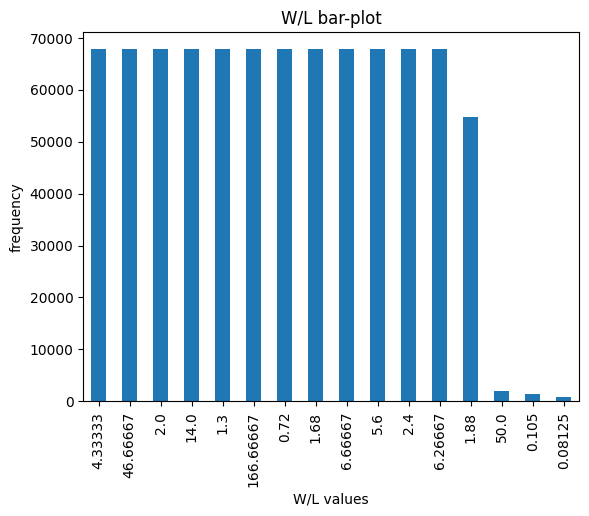

In [6]:
# plot the values and value counts of 'W/L' column
x['W/L'].round(5).value_counts().plot(kind='bar', title='W/L bar-plot')
plt.xlabel('W/L values')
plt.ylabel('frequency')
plt.show()

In [7]:
# separate the output(or label or target) column from the features(input) columns
# where 'x' the feature columns,
# and 'y' is the target column
y = x.pop("id(uA)")

# split the train and test sets and the coresponding labels
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(x, y, test_size=0.21, random_state=seed, shuffle=True)

In [8]:
# apply the needed transformations over the determined columns
col_trans1 = make_column_transformer(("passthrough", ['vgs', 'vds', 'vsb']),
                                    (OneHotEncoder(handle_unknown="infrequent_if_exist"), ['corner']),
                                    (MinMaxScaler(), ['W/L']),
                                     remainder="drop",
                                     n_jobs=-1)

# apply the needed transformations over the training data
xtrain = col_trans1.fit_transform(xtrain_unprocessed)

# apply the needed transformations over the testing data
xtest = col_trans1.transform(xtest_unprocessed)

In [37]:
class CollectedData(Dataset):
    '''create the class to deal with the data convert them into torch tensors, getting the data item and getting the length of the data'''

    def __init__(self, x, y):
        self.data = torch.tensor(x)
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]


    def __getitem__(self, idx):
        '''return the data sample given the index'''

        # return the features and the corresponding label of the given index
        # i convert them to float to solve an error appears while train the model
        return self.data[idx].float(), self.label[idx].float()

    def __len__(self):
        '''function to return the length of the dataset'''

        # return the length of the dataset
        return self.n_smpl

#compine the features and the corresponding labels into one object
train_set = CollectedData(xtrain, ytrain)

#compine the features and the corresponding labels into one object
test_set = CollectedData(xtest, ytest)

In [10]:
## almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels = torch.tensor(ytrain.values.astype(np.float32))
# # test_labels = torch.tensor(ytest.values.astype(np.float32)) #i can do this step now, but i will delay doing this step, to collect all test data preprocessing in one cell
# train_input = torch.tensor(xtrain.values.astype(np.float32))
# # test_input = torch.tensor(xtest.values.astype(np.float32)) #i can do this step now, but i will delay doing this step, to collect all test data preprocessing in one cell

# train_set = TensorDataset(train_input, train_labels)
# # test_set = TensorDataset(test_input, test_labels)


In [46]:
# initializing R2Score function
r2score = R2Score(num_outputs=1, adjusted=0).to(device)

#initializing mean-square-error function
Mean_Square_Error = nn.MSELoss()

# evaluate the performance using the R2Score and mean-square-error pytorch functions
@torch.no_grad()
def evaluate_model(model, data_loader):
    '''this function is to evaluate the performance of the model using R2Score and mean-square-error pytorch functions'''

    # Set the model to eval mode while validating
    model.eval()

    # initialize the labels and preds and transfering them to device(cpu or gpu)
    labels = torch.tensor([]).to(device)
    predictions = torch.tensor([]).to(device)

    # starting the loop over data
    for features, label in data_loader:

        # transfering data to cuda
        features = features.to(device=device)

        # concatenate all the labels
        labels = torch.cat((labels, label), dim=-1)

        # get the model predictions of the given data and flatten them
        preds = model(features).reshape(-1)

        # concatenate all the predictions
        predictions = torch.cat((preds, predictions), dim=-1)

    # calculate the r2score
    r2score_evaluation = r2score(predictions, labels)

    # calculate mean square error loss
    mean_square_error_evaluation = Mean_Square_Error(predictions, labels)

    # return the model to the train mode.
    model.train()

    # return the r2score_accuracy result
    return r2score_evaluation, mean_square_error_evaluation

In [47]:
class network(nn.Module):
    '''create the structure of the model'''

    def __init__(self, in_features=9, out_features=1):
        '''like a class constructor function or initialization'''

        super().__init__()
        # the fully connected layers
        self.fc1 = nn.Linear(in_features, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, out_features)

        # initialize the model parameters(weights, bias)
        self.initialize_weights()


    def forward(self, inpt):
        '''this the the forward path of the model'''

        # relu activation function over the output of the fully connected layed output
        out = F.relu(self.fc1(inpt))

        # leaky_relu activation function over the output of the fully connected layed output
        out = F.leaky_relu(self.fc2(out))

        out = F.leaky_relu(self.fc3(out))
        # out = F.leaky_relu(self.fc4(out))
        # out = F.leaky_relu(self.fc5(out))
        out = F.leaky_relu((self.fc6(out)))
        # out = F.softmax((self.fc6(out)), dim=1)

        # return the result
        return out

    def initialize_weights(self):
        '''initialize the model parameters(W, b)'''

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [51]:
 # define the training function.
def train_model(num_epochs, data_loader):

    # set the number of batches to be the length of 'data_loader'
    num_batches = len(data_loader)

    # print the hyperparameters informations that the model going to train based on.
    print(f"""batch_size = {batch_size} \n starting learning rate = {lr} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # initialize lists to save the training and testing validation progress to be able to plot the results later
    R2Score_train_evaluation_progress = []
    MSE_train_evaluation_progress = []
    R2Score_test_evaluation_progress = []
    MSE_test_evaluation_progress = []

    # start the epochs loop
    for epoch in range(num_epochs):

        # printing out the time which the model starts, to be able to calculate the minuts it take
        start_time = time.time()

        # initialize progress function that display the progress of the training.
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)

        # starting the training loop for each epoch
        for batch_idx, (features, labels) in progress:

            # convert data to device
            features = features.to(device=device)

            # convert labels to device
            labels = labels.to(device=device)

            # calculate the predictions.
            predictions = model(features).reshape(-1)   # reshape(-1 or 0 -the same-) is just as the r2score produce tensor of output shape [batch_size, 1] so to make it's output shape is just [batch_size], i.e flatten it

            # calculate the loss.
            loss = criterion(predictions, labels)

            # back propagation calculations
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            # determine the information to be showed while training progress and show it
            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        # calculate the training accuracy
        R2Score_train_evaluation, MSE_train_evaluation = evaluate_model(model, data_loader=train_loader)

        # calculate the test accuracy
        R2Score_test_evaluation, MSE_test_evaluation = evaluate_model(model, data_loader=test_loader)

        # take learning-rate schedular step
        schedular.step(R2Score_test_evaluation)

        # printing the important information about the training progress
        print(f"after {1+epoch} epoch, train_evaluation = {R2Score_train_evaluation*100:.2f}%, test_evaluation = {R2Score_test_evaluation*100:.2f}%,\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*139)

        # add the training R2Score evaluation to a list to be able to visulaize the over all progress after the training completed
        R2Score_train_evaluation_progress += [R2Score_train_evaluation]

        # the same but with mean square error
        MSE_train_evaluation_progress += [MSE_train_evaluation]

        # add the test accuracy to a list to be able to visulaize the over all progress after the training completed
        R2Score_test_evaluation_progress += [R2Score_test_evaluation]

        # the same but with mean square error
        MSE_test_evaluation_progress += [MSE_test_evaluation]

        # stop the training in case the model reached to the optimum accuracy even if the epochs didn't ended
        if R2Score_test_evaluation==1.0 and R2Score_train_evaluation==1.0:
            print("the model reached to the optimum accuracy at the epoch({epoch}/{num_epochs})")
            return train_evaluation_progress, test_evaluation_progress

    # return result_train_evaluation, result_test_evaluation after the training completed
    return (R2Score_train_evaluation_progress,
            MSE_train_evaluation_progress,
            R2Score_test_evaluation_progress,
            MSE_test_evaluation_progress)

In [ ]:
# from this cell you can adjust/tune almost all the hyper paremeters,
# except the model structure which can be adjusted from the previous cell

# initializing the model and convert it to device(gpu or cpu)
model = network().to(device)

# print the model structure
print(model)

# the Learning Rate hyperparameter
lr = 0.005

# loss initializing
criterion = R2Score(num_outputs=1, adjusted=0)
criterion = nn.MSELoss()

# optimizer initializing
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#learning-rate schedular initialization
# i used values here to elimiate this function effect, as i found i don't need it now, and i didn't remove it totally
# to be able to call it again just by modify the factor and patience values without change any other part of the code
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5, verbose=True)

# determine number of calculations
num_epochs = 27

# set the batch size
batch_size = 512 #4096

# create the train_loader object
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)

# create the test_loader object
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)


# call the training function
(R2Score_train_evaluation_progress,
MSE_train_evaluation_progress,
R2Score_test_evaluation_progress,
MSE_test_evaluation_progress) = train_model(num_epochs, data_loader=train_loader)

network(
  (fc1): Linear(in_features=9, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=1, bias=True)
)
batch_size = 512 
 starting learning rate = 0.005 
 number of epochs = 27   
 number of batches = 1345 
 model = network(
  (fc1): Linear(in_features=9, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=1, bias=True)
), 
 criterion=MSELoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: Fal

epoch [1/27], loss=99658.5938: 100%|██████████| 1345/1345 [00:30<00:00, 43.79it/s]


after 1 epoch, train_evaluation = -93.36%, test_evaluation = -93.49%,       time_elapsed = 0.9 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [2/27], loss=160601.9062: 100%|██████████| 1345/1345 [00:42<00:00, 31.60it/s]


after 2 epoch, train_evaluation = -91.73%, test_evaluation = -91.63%,       time_elapsed = 1.1 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [3/27], loss=68651.9062: 100%|██████████| 1345/1345 [00:46<00:00, 29.01it/s]


after 3 epoch, train_evaluation = -89.10%, test_evaluation = -89.35%,       time_elapsed = 1.1 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [4/27], loss=16374.5703: 100%|██████████| 1345/1345 [00:36<00:00, 36.82it/s]


after 4 epoch, train_evaluation = -98.35%, test_evaluation = -98.19%,       time_elapsed = 1.0 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [5/27], loss=6955.3125: 100%|██████████| 1345/1345 [00:30<00:00, 44.81it/s]


after 5 epoch, train_evaluation = -95.19%, test_evaluation = -95.10%,       time_elapsed = 0.9 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [6/27], loss=2443.1145: 100%|██████████| 1345/1345 [00:30<00:00, 43.48it/s]


after 6 epoch, train_evaluation = -100.45%, test_evaluation = -100.47%,       time_elapsed = 0.9 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [7/27], loss=4013.6692: 100%|██████████| 1345/1345 [00:35<00:00, 37.91it/s]


after 7 epoch, train_evaluation = -97.71%, test_evaluation = -97.99%,       time_elapsed = 0.9 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [8/27], loss=2986.1218: 100%|██████████| 1345/1345 [00:31<00:00, 43.24it/s]


after 8 epoch, train_evaluation = -98.73%, test_evaluation = -98.83%,       time_elapsed = 0.8 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [9/27], loss=4469.4912: 100%|██████████| 1345/1345 [00:31<00:00, 42.13it/s]


after 9 epoch, train_evaluation = -99.16%, test_evaluation = -99.55%,       time_elapsed = 0.8 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [10/27], loss=2277.6350: 100%|██████████| 1345/1345 [00:30<00:00, 44.29it/s]


after 10 epoch, train_evaluation = -99.18%, test_evaluation = -99.10%,       time_elapsed = 0.8 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [11/27], loss=1825.8314: 100%|██████████| 1345/1345 [00:29<00:00, 45.50it/s]


after 11 epoch, train_evaluation = -100.31%, test_evaluation = -100.49%,       time_elapsed = 0.8 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [12/27], loss=2324.3423: 100%|██████████| 1345/1345 [00:32<00:00, 41.54it/s]


after 12 epoch, train_evaluation = -100.30%, test_evaluation = -99.80%,       time_elapsed = 0.9 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [13/27], loss=1504.1840: 100%|██████████| 1345/1345 [00:35<00:00, 37.94it/s]


after 13 epoch, train_evaluation = -101.61%, test_evaluation = -102.14%,       time_elapsed = 1.0 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [14/27], loss=1448.4819: 100%|██████████| 1345/1345 [00:33<00:00, 40.65it/s]


after 14 epoch, train_evaluation = -99.36%, test_evaluation = -99.65%,       time_elapsed = 1.0 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [15/27], loss=1936.5571: 100%|██████████| 1345/1345 [00:41<00:00, 32.26it/s]


after 15 epoch, train_evaluation = -97.66%, test_evaluation = -98.07%,       time_elapsed = 1.1 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [16/27], loss=1382.1687: 100%|██████████| 1345/1345 [00:44<00:00, 30.28it/s]


after 16 epoch, train_evaluation = -101.49%, test_evaluation = -101.75%,       time_elapsed = 1.1 minuts. 
 -------------------------------------------------------------------------------------------------------------------------------------------


epoch [17/27], loss=2211.0596:  29%|██▉       | 395/1345 [00:08<00:29, 31.80it/s]

why i print maximum accuracy the model reached? as sometimes the model reach to a very good accuracy then it's accuracy degraded, but the point is as long as the model can to reach to that good accuracy then i need to know that to figure out if i'm close to optimum hyperparameters or no and to decide if i need to change the hyperparameters with small scale or large one.

In [ ]:
# printing the maximum training accuracy and maximum testing accuracy the model reached
print(f"maximun R2Score training evaluation={(max(R2Score_train_evaluation_progress)):.2f}\
%\nmaximun R2Score test evaluation={(max(R2Score_test_evaluation_progress)):.2f}%\
maximun MSE training evaluation={(max(MSE_train_evaluation_progress)):.2f}\
%\nmaximun MSE test evaluation={(max(MSE_test_evaluation_progress)):.2f}%")


### plot the overall training and testing accuracy progress

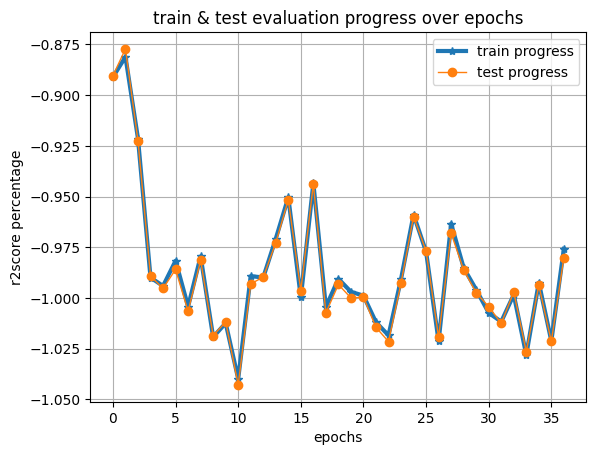

In [26]:
def plot_evaluation(train_progress, test_progress):
    '''function to plot the progress of training and testing data'''

    # convert the train accuracy list into numpy array.
    train_line_val = np.array([val.cpu() for val in train_progress])
    # convert the train accuracy list into numpy array.
    test_line_val = np.array([val.cpu() for val in test_progress])

    # plot the progress of training accuracy over epochs.
    train_progress, = plt.plot((range(len(train_line_val))), train_line_val, label="train progress", marker="*", linewidth=3)
    # plot the progress of testing accuracy over epochs.
    test_progress, = plt.plot((range(len(test_line_val))), test_line_val, label="test progress", marker="o", linewidth=1)

    # set the legend parameters.
    plt.legend(loc="best", handles=[train_progress, test_progress])
    # write the figure title.
    plt.title(f"train and {test_progress} over epochs")
    # write the label of x axis.
    plt.xlabel("epochs")
    # write the label of y axis.
    plt.ylabel("validation percentage")
    # add grid to the figure
    plt.grid()
    # to show the figure and remove any unwanted appered words
    plt.show()

plot_evaluation(R2Score_train_evaluation_progress, R2Score_test_evaluation_progress)
plot_evaluation(MSE_train_evaluation_progress, MSE_test_evaluation_progress)

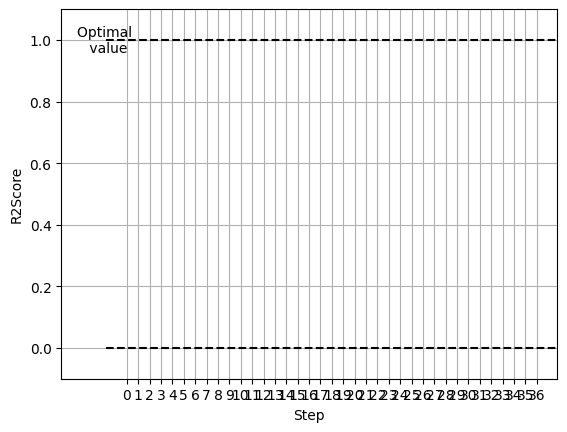

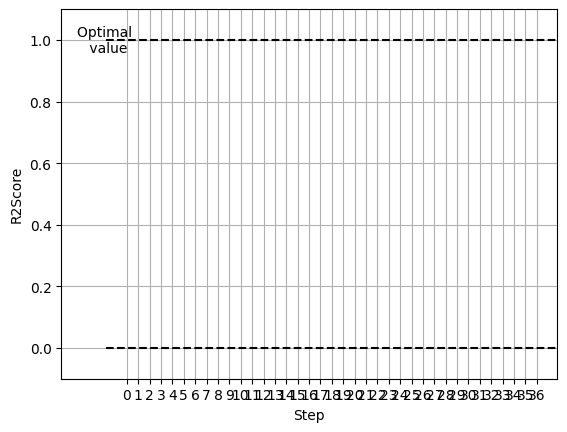

In [27]:
fig, ax = r2score.plot(train_evaluation_progress)
fig, ax = r2score.plot(test_evaluation_progress)

In [ ]:
# # #save the trained model to disk
filename = 'finalized_pytorch_model.sav'
joblib.dump(model, filename)
# # # to load the model from disk
loaded_model = joblib.load(filename)



# # # another way to save the trained model
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

# # # to load the model from disk
# #loaded_model = pickle.load(open(filename, 'rb'))

### make the preprocessing steps on the test data


In [ ]:
# first thing first don't forget to create the "W(um)/L(um)" new column

# apply the needed transformations over testing data.
xtest = col_trans1.transform(xtest_unprocessed)

# compine features and the corresponding labels in an object.
test_set = CollectedData(xtest, ytest)

# # almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# test_labels = torch.tensor(ytest.values.astype(np.float32))
# test_input = torch.tensor(xtest.values.astype(np.float32))
# test_set = TensorDataset(test_input, test_labels)

# split the test data into batches to be eaisly to deal with.
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

In [33]:
# initialize the labels and preds and transfering them to device(cpu or gpu)
labels = torch.tensor([]).to(device)
predictions = torch.tensor([]).to(device)

# starting the loop over data
for features, label in test_loader:

    # transfering data to cuda
    features = features.to(device=device)

    # concatenate all the labels
    labels = torch.cat((labels, label), dim=-1)

    # get the model predictions of the given data and flatten them
    preds = model(features).reshape(-1)

    # concatenate all the predictions
    predictions = torch.cat((preds, predictions), dim=-1)

# calculate the r2score
r2score_evaluation = r2score(predictions, labels)

# calculate the r2score
MSE-loss_evaluation = r2score(predictions, labels)

# calculate the r2score
MAE-loss_evaluation = r2score(predictions, labels)

# calculate the r2score
RMSE-loss_evaluation = r2score(predictions, labels)

SyntaxError: ignored